### Установка пакетов

In [10]:
!pip install pyspark

### Импорт библиотек

In [11]:
import json
import matplotlib.pyplot as plt
import random
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, mean, max, min, col, sum, format_string
import os

### Генерация номера задания

In [12]:
# random.randint(1, 200)

Сгенерирован номер с заданием 99

### Создание каталога data для хранения данных

In [13]:
if not os.path.exists('data'):
  os.makedirs('data')

### Создание экземпляра SparkSession

In [14]:
spark = SparkSession.builder.appName('Homework_3_lab2').getOrCreate()

### Задание 1. Считать файл 2.csv и создать Spark DataFrame

In [15]:
df = spark.read.format('csv').option('header', 'true').load('data/2.csv')
df.show(5)

+----------+--------------------+-----+--------+-----------------+--------------------+---------------+---------------+------+---------+
|product_id|                name|price|quantity|         category|         description|production_date|expiration_date|rating|   status|
+----------+--------------------+-----+--------+-----------------+--------------------+---------------+---------------+------+---------+
|         1|Пакеты для мастер...| 7877|     367|  Товары для дома|Помогает поддержи...|     2017-04-03|     2020-06-08|  2.61|Delivered|
|         2|   Грудинка копченая| 4199|     492|             Мясо|Имеет низкий глик...|     2002-04-06|     2006-08-09|  0.16| In Stock|
|         3|Орехи (грецкий ор...| 1037|     385|          Бакалея|Обладает приятным...|     2009-01-22|     2015-01-02|  2.58| Refunded|
|         4|           Крыжовник| 8055|     877|           Фрукты|Помогает снизить ...|     2005-01-13|     2012-01-08|  2.43| In Stock|
|         5|               Айран| 3445|  

### 2. Выполнить группировку по колонке категориальных данных category, а также приведенные агрегации по колонке quantity (частота, среднее, максимальное, минимальное, процент от общего числа)

In [16]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_grouped = df.select(['category', 'quantity']) \
  .groupby('category') \
  .agg(
    count('quantity').alias('count'),
    mean('quantity').alias('mean_quantity'),
    max('quantity').alias('max_quantity'),
    min('quantity').alias('min_quantity')
  ) \
  .withColumn('total', sum(col('count')).over(window)) \
  .withColumn('percent', col('count') / col('total') * 100) \
  .withColumn('percent (%)', format_string('%5.0f%%', col('percent'))) \
  .drop("total")

df_grouped.show()

+-----------------+-----+------------------+------------+------------+------------------+-----------+
|         category|count|     mean_quantity|max_quantity|min_quantity|           percent|percent (%)|
+-----------------+-----+------------------+------------+------------+------------------+-----------+
|          Бакалея|  187| 483.3155080213904|         995|         100|15.020080321285139|        15%|
|Молочные продукты|  174|461.63793103448273|         995|         102|13.975903614457833|        14%|
|             Мясо|  178|498.80337078651684|         999|           1|14.297188755020079|        14%|
|          Напитки|  177| 482.5875706214689|         995|         103|14.216867469879519|        14%|
|            Овощи|  174| 527.1034482758621|         998|         104|13.975903614457833|        14%|
|  Товары для дома|  169|485.20710059171597|         994|         101|13.574297188755018|        14%|
|           Фрукты|  186|500.26881720430106|         987|         103| 14.93975903

### 3. Построить круговую диаграмму, отражающую общее распределение по значениям категориальной колонки

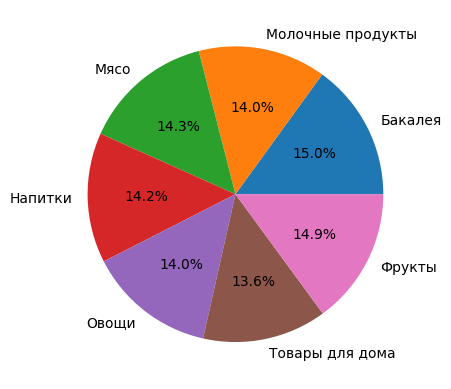

In [17]:
df_plot = df_grouped.toPandas()

plot_labels = df_plot.category
plot_data = df_plot.percent

plt.pie(plot_data, labels=plot_labels, autopct='%1.1f%%')
plt.show()

### Задание 4. Записать полученные данные (п. 2) в файл JSON

In [18]:
with open('data/r_3.json', 'w') as file:
  file.write(df_grouped.toJSON().collect()[0])